# Getting and Visualizing The Data

In [5]:
#install the important libraries
import pandas as pd
from pandas_datareader import data as web   # Package and modules for importing data; this code may change depending on pandas version
import datetime

In [6]:
# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()

In [7]:
# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
apple = web.DataReader("AAPL", "yahoo", start, end)
 
type(apple)

pandas.core.frame.DataFrame

In [8]:
apple.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,105.370003,102.000000,102.610001,105.349998,67649400.0,99.925850
2016-01-05,105.849998,102.410004,105.750000,102.709999,55791000.0,97.421768
2016-01-06,102.370003,99.870003,100.559998,100.699997,68457400.0,95.515244
2016-01-07,100.129997,96.430000,98.680000,96.449997,81094400.0,91.484085
2016-01-08,99.110001,96.760002,98.550003,96.959999,70798000.0,91.967812


# Visualizing the Stock Data
Now that we have stock data we would like to visualize it. I first demonstrate how to do so using the matplotlib package. Notice that the apple DataFrame object has a convenience method, plot(), which makes creating plots easier.


Populating the interactive namespace from numpy and matplotlib


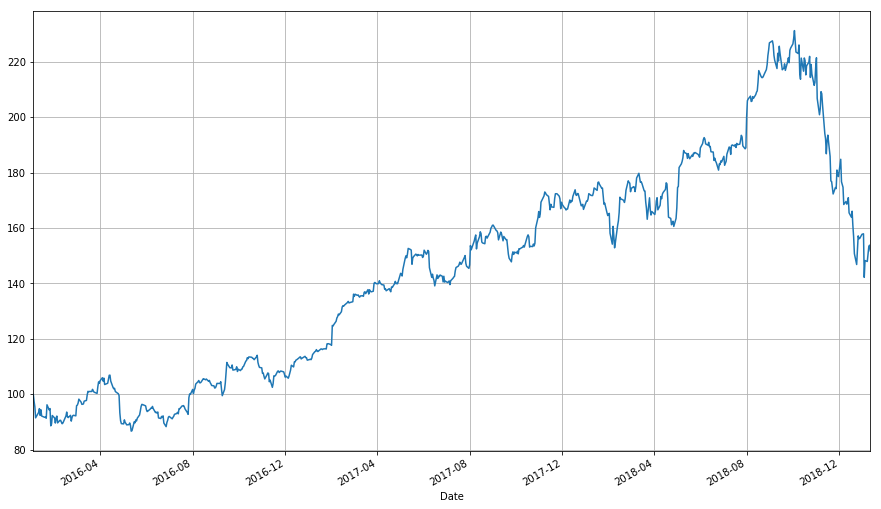

In [9]:
import matplotlib.pyplot as plt   
# Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
apple["Adj Close"].plot(grid = True) # Plot the adjusted closing price of AAPL

A linechart is fine, but there are at least four variables involved for each date (open, high, low, and close), and we would like to have some visual way to see all four variables that does not require plotting four separate lines. Financial data is often plotted with a Japanese candlestick plot, so named because it was first created by 18th century Japanese rice traders. Such a chart can be created with matplotlib, though it requires considerable effort.

lets make a function to create candlestick charts from pandas data frames, and use it to plot our stock data.

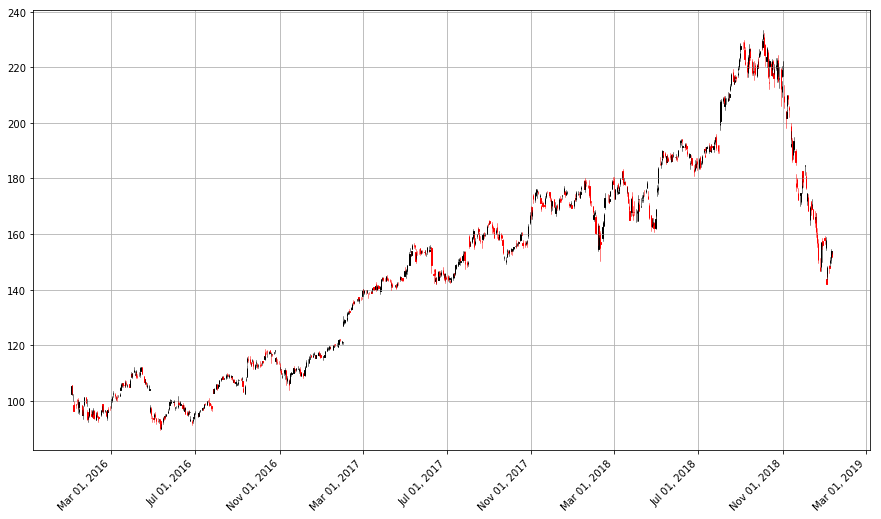

In [10]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(apple)

In [11]:
#lets compare the apple stock with other tech company stock
#getting stock for google and microsoft
microsoft = web.DataReader("MSFT", "yahoo", start, end)
google = web.DataReader("GOOG", "yahoo", start, end)
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, 
#first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})
 
stocks.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,99.925850,741.840027,51.283730
2016-01-05,97.421768,742.580017,51.517689
2016-01-06,95.515244,743.619995,50.581856
2016-01-07,91.484085,726.390015,48.822487
2016-01-08,91.967812,714.469971,48.972225


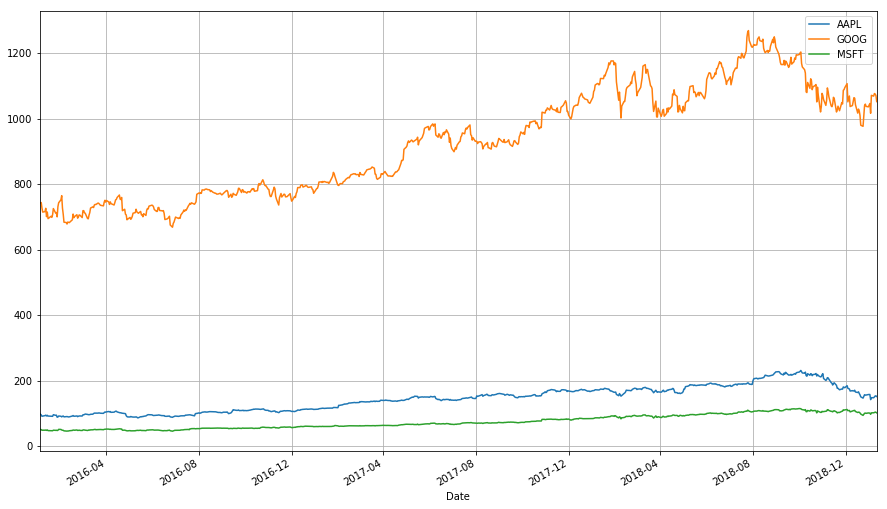

In [12]:
stocks.plot(grid = True)

Google’s stocks are much more expensive than Apple’s or Microsoft’s, and this difference makes Apple’s and Microsoft’s stocks appear much less volatile than they truly are.
One solution would be to use two different scales when plotting the data; one scale will be used by Apple and Microsoft stocks, and the other by Google.

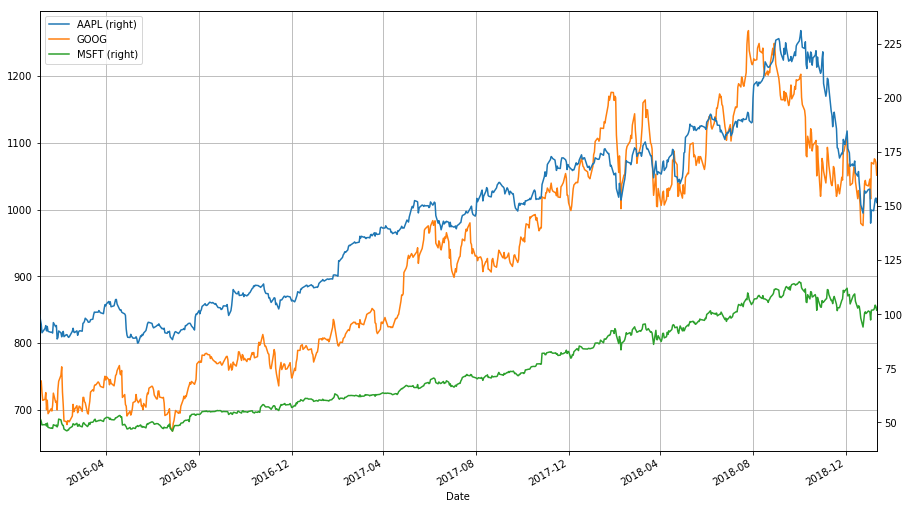

In [13]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

In [14]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,1.000000,1.000000,1.000000
2016-01-05,0.974941,1.000998,1.004562
2016-01-06,0.955861,1.002399,0.986314
2016-01-07,0.915520,0.979173,0.952007
2016-01-08,0.920361,0.963105,0.954927


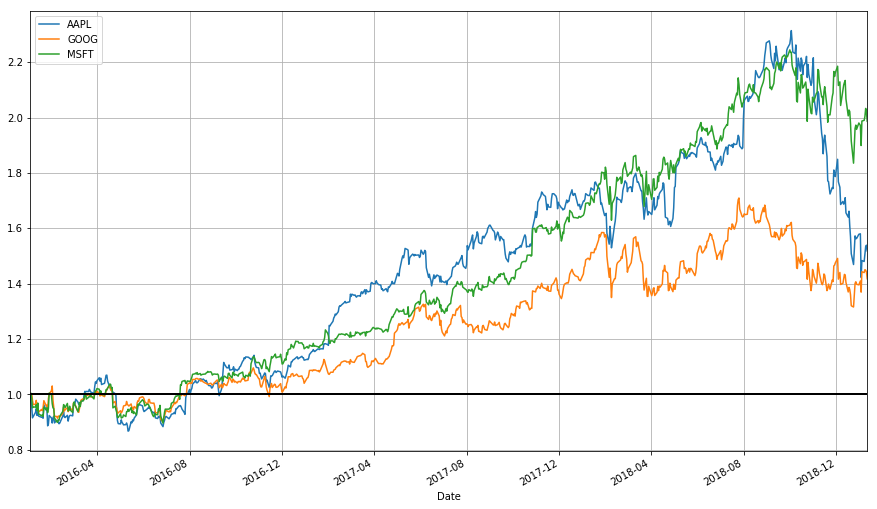

In [15]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

In [16]:
# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,NaN,NaN,NaN
2016-01-05,-0.025379,0.000997,0.004552
2016-01-06,-0.019764,0.001400,-0.018332
2016-01-07,-0.043121,-0.023443,-0.035402
2016-01-08,0.005274,-0.016546,0.003062


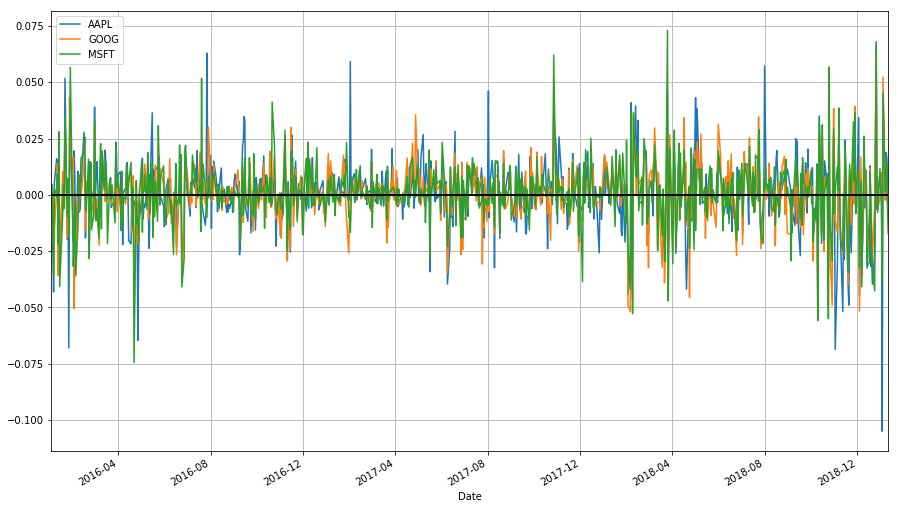

In [17]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)